Notebook (easier to see)

In [1]:
import numpy as np
import math
from matplotlib import pyplot
%matplotlib inline
from scipy.io import loadmat
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [2]:
__tab_colors = ["hotpink", "dodgerblue", "coral", "silver", "darkcyan"]
__color_index = -1
def next_color():
    global __color_index
    __color_index += 1
    index = __color_index%len(__tab_colors)
    return __tab_colors[index]
def reset_color():
    global __color_index
    __color_index = -1

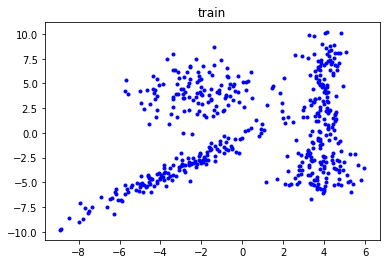

In [3]:
# fonction pour lire un fichier
def loadfile(strfile):
    fileo = open(strfile, "r") 
    y = []
    for line in fileo: 
        y.append(list(map(float, line.split())))
    fileo.close()
    return np.array(y)
    
# load trains
emTrain = loadfile("EMGaussian.data")
emTest = loadfile("EMGaussian.test")

def show(data, name, show=True):
    dataT = np.transpose(data)
    pyplot.scatter(dataT[0], dataT[1], c = "blue", marker = '.')
    pyplot.title(name)
    if show:
        pyplot.show()
show(emTrain, "train")

In [4]:
def K_Means(data, K):
    n = data.shape[0]
    
    # initialise at K random cluster
    index = np.arange(n)
    np.random.shuffle(index)
    mu = data[index[0:K]]

    oldC = np.zeros(n)
    while "The algorithm has not converged":
        # assign each point to the closest centroid
        newC = np.zeros(n)
        Cdic = [[] for k in range(K)]
        for i in range(n):
            clus = np.argmin(np.linalg.norm(mu - data[i], axis = 1))
            newC[i] = clus
            Cdic[clus].append(i)
        # recompute centroid
        for k in range(K):
            mu[k] = (1./len(Cdic[k]))*np.sum(data[Cdic[k]], axis=0)
        
        # if it has converged
        if (newC == oldC).all():
            break
        oldC = newC
    return Cdic, mu

In [5]:
def show_K_colors(data, name, K, clusters, centroids, axe):
    reset_color()
    for k in range(K):
        dataT = np.transpose(data[clusters[k]])
        c = next_color()
        axe.scatter(dataT[0], dataT[1], c=c, marker = '.')
        axe.scatter(centroids[k][0], centroids[k][1], c="black", marker = 'o', s=50)
        axe.set_title(name)

In [6]:
def show_2x2(data, name):
    f, axes = pyplot.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
    for K in range(2, 6):
        axe = axes[(K-2)//2][(K-2)%2]
        clusters, centroids = K_Means(data, K)
        show_K_colors(data, "K="+str(K), K, clusters, centroids, axe)
    pyplot.suptitle("K Means on "+name)
    pyplot.show()

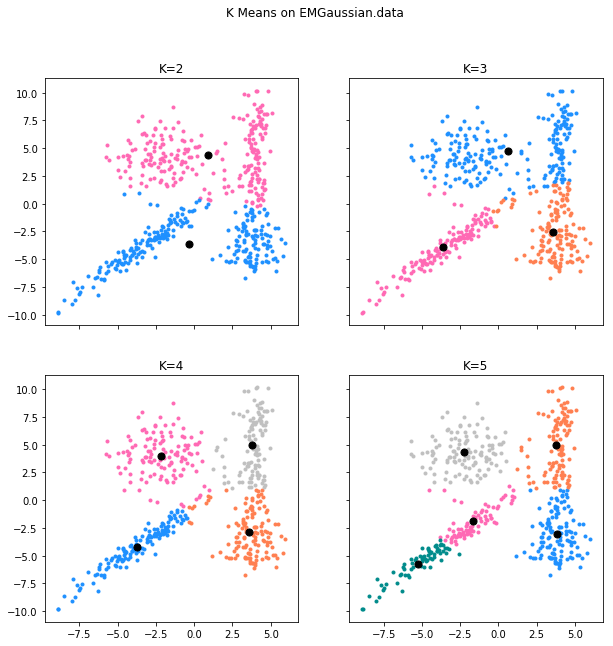

In [7]:
show_2x2(emTrain, "EMGaussian.data")

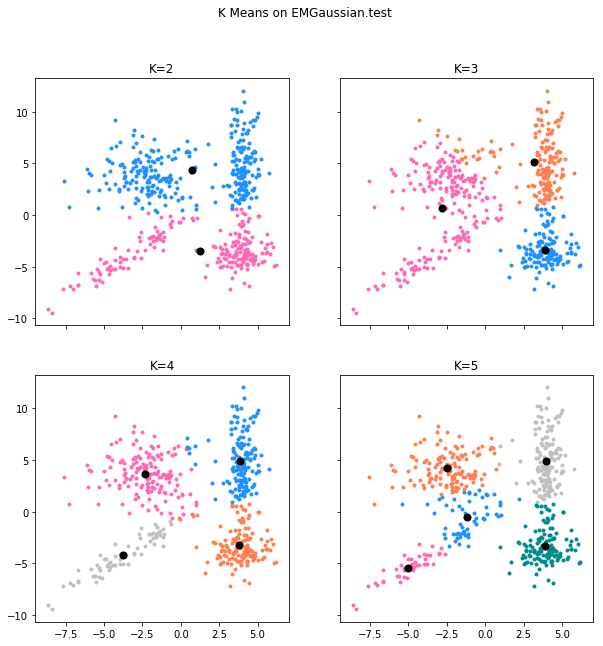

In [8]:
show_2x2(emTest, "EMGaussian.test")

In [9]:
def show_2x2_random_4(data, name):
    f, axes = pyplot.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
    for K in range(2, 6):
        axe = axes[(K-2)//2][(K-2)%2]
        clusters, centroids = K_Means(data, 4)
        show_K_colors(data, "K="+str(4), 4, clusters, centroids, axe)
    pyplot.suptitle("K Means K=4, "+name)
    pyplot.show()

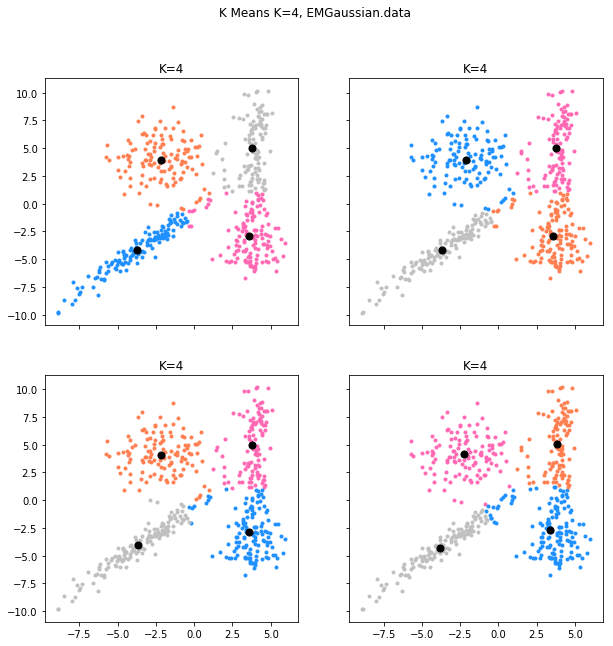

In [10]:
show_2x2_random_4(emTrain, "EMGaussian.data")

**Comment**: Initilisation are random but results seems to be the same

In [11]:
def EM_algorithm_isotropic(data, K):
    #initialisation with K_Means
    n, d = data.shape
    # initialise mu
    clusters, oldmu = K_Means(data, K)
    
    # initialise pi
    pi = np.array([len(clusters[k]) for k in range(K)])
    pi = pi / np.sum(pi)
    
    # initialise isotropic sigma_k = v_k Id
    vsigma = np.ones((K))
    Id = np.identity(d)
    # initialise q
    q = np.zeros((n,K))
    while "The algorithm has not converged":
        # E step
        normal = np.array([multivariate_normal.pdf(data, oldmu[k], vsigma[k]*Id) for k in range(K)])
        denom = np.dot(normal.T, pi)
        denom = np.broadcast_to(denom, (K,n)).T
        pimul = np.broadcast_to(pi, (n,K))
        mul = pimul/denom
        q = (mul*normal.T)

        # M step
        # mu computation
        num = np.dot(q.T, data)
        denom = np.broadcast_to(np.sum(q, axis=0), (d,K)).T
        newmu = num/denom
        
        # pi computation
        pi = np.sum(q, axis=0) / np.sum(q)
        
        # sigma computation
        # numerator
        gdata = np.broadcast_to(data, (K,n,d))
        gmu = np.broadcast_to(newmu, (n,K,d)).transpose(1,0,2)
        prod = gdata-gmu
        num = np.einsum('...a,...b', prod, prod)
        num = np.einsum('...ii', num).transpose(1,0)
        num = np.einsum('ab,ab->b', num, q)
        # denominator
        denom = np.sum(q, axis=0)
        vsigma = num/denom
        
        # sigma test
        for k in range(K):
            susuk = 0
            for i in range(n):
                susuk += np.linalg.norm(data[i]-newmu[k])**2 * q[i,k]
            vsigma[k] = susuk / (d*np.sum(q[:,k]))
            
        if (np.linalg.norm(newmu - oldmu)) < 0.01:
            break
        oldmu = newmu
    return vsigma,newmu,pi,q

vsigma,mu,pi,q = EM_algorithm_isotropic(emTrain, 4)

In [12]:
def show_K_colors_ellipse_isotropic(data, name, K, clusters, mu, vsigma, axe):
    reset_color()
    for k in range(K):
        # Ellipse part, here 90%
        s = -2*np.log(1-0.90)
        theta = 90
        w = 2*np.sqrt(s*vsigma[k])
        h = w
        ell = Ellipse(xy=(mu[k][0], mu[k][1]),
                      width=w, height=h,
                      angle=theta)
        ell.set_color("black")
        ell.set_facecolor('none')
        axe.add_artist(ell)
        
        # scatter
        dataT = np.transpose(data[clusters[k]])
        axe.scatter(dataT[0], dataT[1], c=next_color(), marker = '.')
        axe.scatter(mu[k][0], mu[k][1],c="black", marker = 'o', s=50)
        axe.set_title(name)
        
        
def show_2x2_EM_isotropic(data, name):
    f, axes = pyplot.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
    for K in range(2, 6):
        axe = axes[(K-2)//2][(K-2)%2]
        vsigma,mu,pi,q = EM_algorithm_isotropic(data, K)
        amax = np.argmax(q, axis=1)
        clusters = [np.argwhere(amax==k).reshape(-1) for k in range(K)]
        show_K_colors_ellipse_isotropic(data, "K="+str(K), K, clusters, mu, vsigma, axe)

    pyplot.suptitle("EM isotropic, "+name)
    pyplot.show()
    

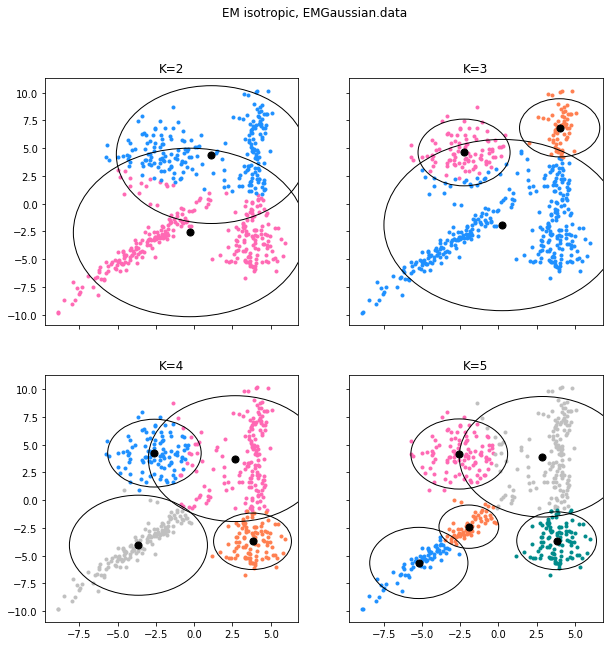

In [13]:
show_2x2_EM_isotropic(emTrain, "EMGaussian.data")

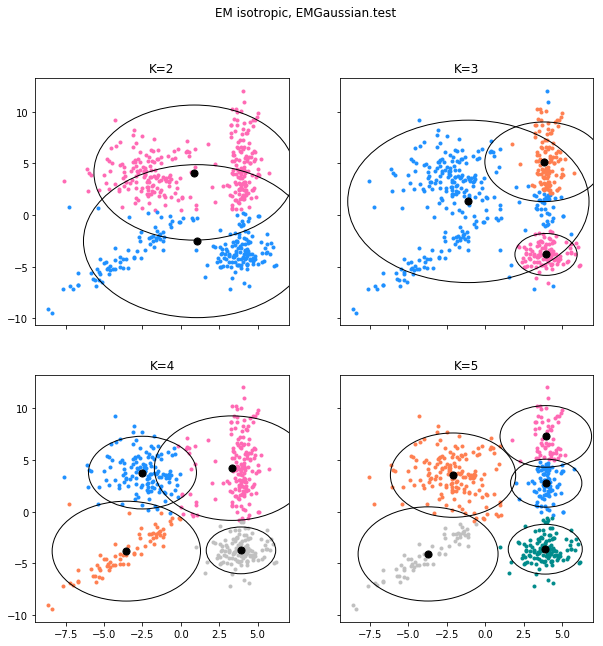

In [14]:
show_2x2_EM_isotropic(emTest, "EMGaussian.test")

In [15]:
def show_2x2_4_EM_isotropic(data, name):
    f, axes = pyplot.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
    for K in range(2, 6):
        axe = axes[(K-2)//2][(K-2)%2]
        sigma,mu,pi,q = EM_algorithm_isotropic(data, 4)
        amax = np.argmax(q, axis=1)
        clusters = [np.argwhere(amax==k).reshape(-1) for k in range(4)]
        show_K_colors_ellipse_isotropic(data, "K="+str(4), 4, clusters, mu, sigma, axe)
    pyplot.suptitle("EM isotropic, "+name)
    pyplot.show()

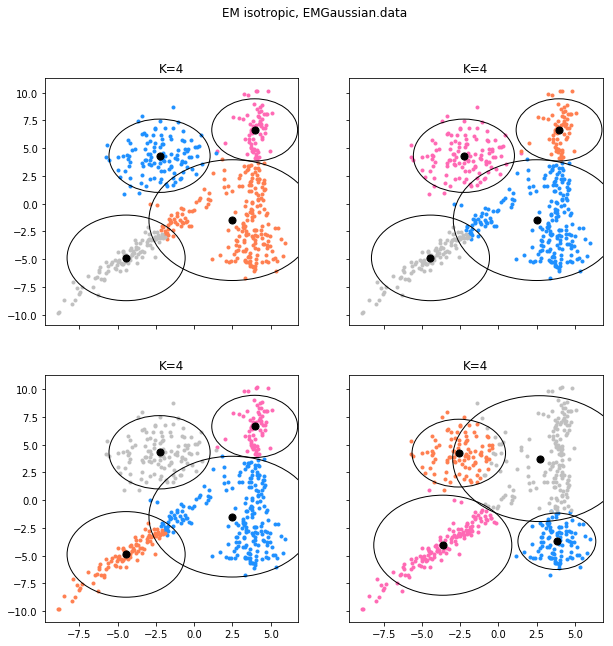

In [16]:
show_2x2_4_EM_isotropic(emTrain, "EMGaussian.data")

In [17]:
def EM_algorithm(data, K):
    #initialisation with K_Means
    n, d = data.shape
    
    # initialise mu
    clusters, oldmu = K_Means(data, K)
    
    # initialise pi
    pi = np.array([len(clusters[k]) for k in range(K)])
    pi = pi / np.sum(pi)
    
    # initialise sigma
    sigma = np.array([np.identity(d) for k in range(K)])
    
    # initialise q
    q = np.zeros((n,K))
    while "The algorithm has not converged":
        # E step
        normal = np.array([multivariate_normal.pdf(data, oldmu[k], sigma[k]) for k in range(K)])
        denom = np.dot(normal.T, pi)
        denom = np.broadcast_to(denom, (K,n)).T
        pimul = np.broadcast_to(pi, (n,K))
        mul = pimul/denom
        q = (mul*normal.T)

        # M step
        # mu computation
        num = np.dot(q.T, data)
        denom = np.broadcast_to(np.sum(q, axis=0), (d,K)).T
        newmu = num/denom
        
        # pi computation
        pi = np.sum(q, axis=0) / np.sum(q)

        # sigma computation
        # numerator
        gdata = np.broadcast_to(data, (K,n,d))
        gmu = np.broadcast_to(newmu, (n,K,d)).transpose(1,0,2)
        prod = gdata-gmu
        num = np.einsum('...a,...b', prod, prod).transpose(2,3,1,0)
        num = np.einsum('...ab,ab->...b', num, q).transpose(2,1,0)
        # denominator
        denom = np.broadcast_to(np.sum(q, axis=0), (d,d,K)).T
        
        sigma = num/denom
        
        if (np.linalg.norm(newmu - oldmu)) < 0.01:
            break
        oldmu = newmu
    
    return sigma,newmu,pi,q

In [18]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

In [19]:
def show_K_colors_ellipse(data, name, K, clusters, mu, sigma, axe):
    reset_color()
    for k in range(K):
        # Ellipse part, here 90%
        s = -2*np.log(1-0.90)
        vals, vecs = eigsorted(s*sigma[k])
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        w, h = 2 * np.sqrt(vals)
        ell = Ellipse(xy=(mu[k][0], mu[k][1]),
                      width=w, height=h,
                      angle=theta)
        ell.set_color("black")
        ell.set_facecolor('none')
        axe.add_artist(ell)
        
        # scatter
        dataT = np.transpose(data[clusters[k]])
        axe.scatter(dataT[0], dataT[1], c=next_color(), marker = '.')
        axe.scatter(mu[k][0], mu[k][1],c="black", marker = 'o', s=50)
        axe.set_title(name)
        
        
def show_2x2_EM(data, name):
    f, axes = pyplot.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
    for K in range(2, 6):
        axe = axes[(K-2)//2][(K-2)%2]
        sigma,mu,pi,q = EM_algorithm(data, K)
        amax = np.argmax(q, axis=1)
        clusters = [np.argwhere(amax==k).reshape(-1) for k in range(K)]
        show_K_colors_ellipse(data, "K="+str(K), K, clusters, mu, sigma, axe)

    pyplot.suptitle("EM algorithm, "+name)
    pyplot.show()
    

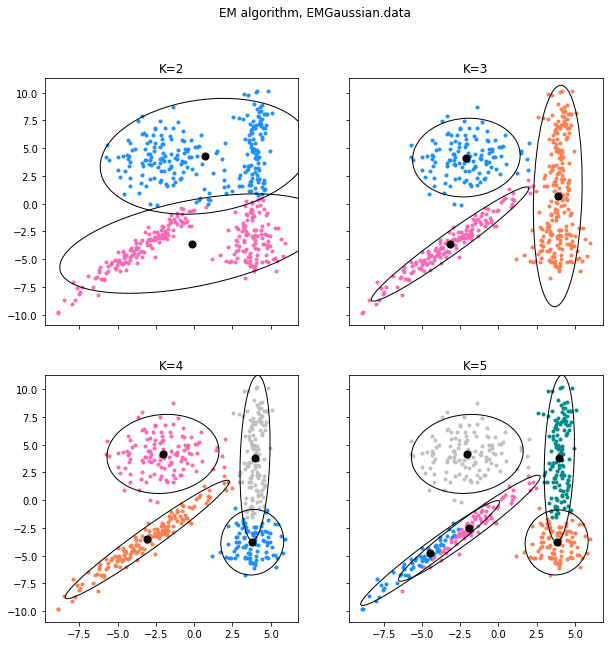

In [20]:
show_2x2_EM(emTrain, "EMGaussian.data")

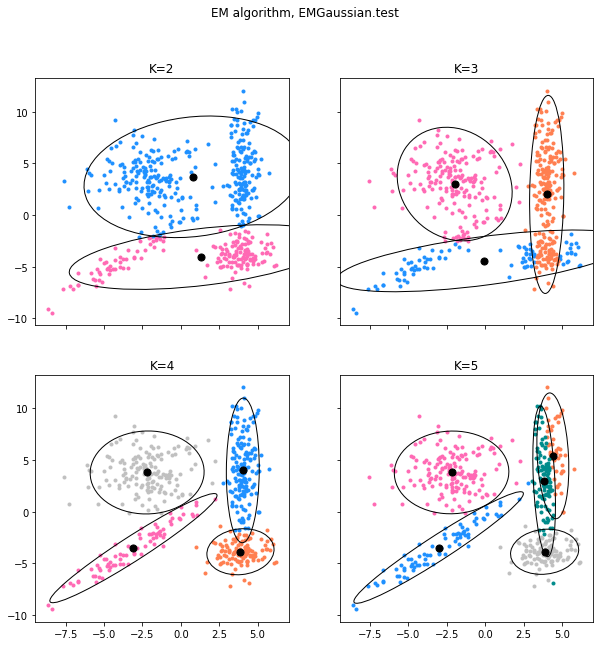

In [21]:
show_2x2_EM(emTest, "EMGaussian.test")

In [22]:
def show_2x2_4_EM(data, name):
    f, axes = pyplot.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
    for K in range(2, 6):
        axe = axes[(K-2)//2][(K-2)%2]
        sigma,mu,pi,q = EM_algorithm(data, 4)
        amax = np.argmax(q, axis=1)
        clusters = [np.argwhere(amax==k).reshape(-1) for k in range(4)]
        show_K_colors_ellipse(data, "K="+str(4), 4, clusters, mu, sigma, axe)
    pyplot.suptitle("EM algorithm, "+name)
    pyplot.show()

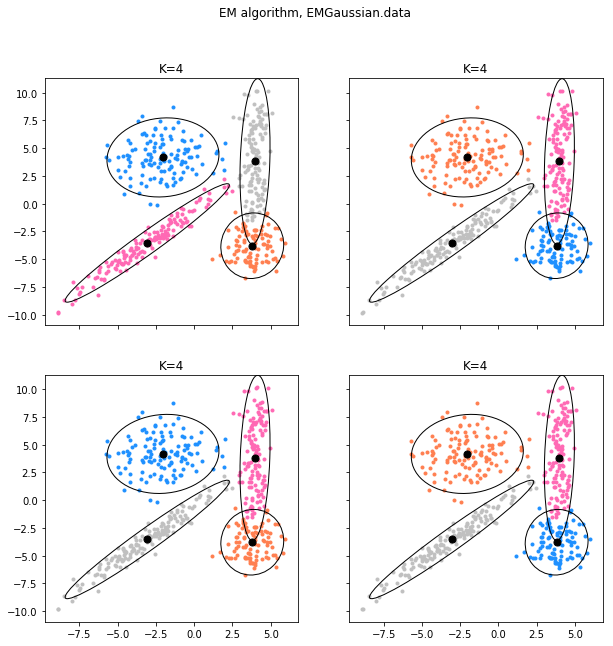

In [23]:
show_2x2_4_EM(emTrain, "EMGaussian.data")

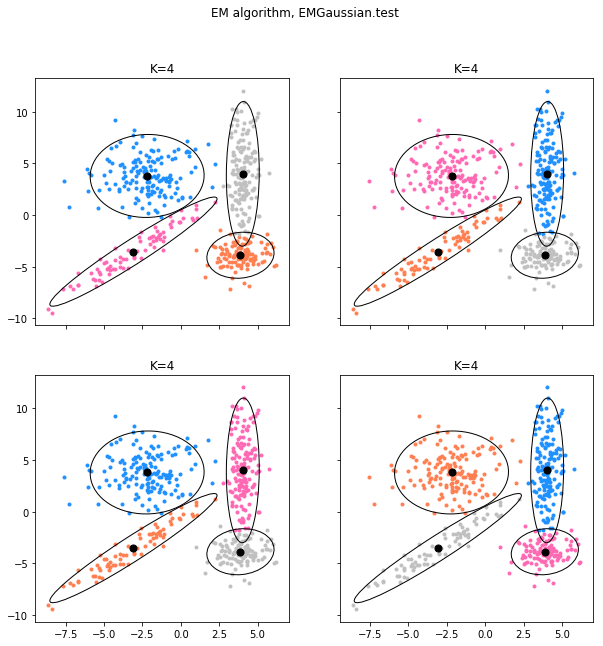

In [24]:
show_2x2_4_EM(emTest, "EMGaussian.test")

In [25]:
def log_likelihood(data, mu, sigma, q, pi, K):
    normal = np.array([multivariate_normal.pdf(data, mu[k], sigma[k]) for k in range(K)])
    lognormal = np.log(normal)    
    sum1 = np.einsum("ij,ij", q.T, lognormal)
    sum2 = np.einsum("ij,j->", q, pi) 
    return sum1 + sum2

def log_likelihood_all(data, K):
    vsigma,mu,pi,q = EM_algorithm_isotropic(data, K)
    sigma = np.array([v*np.identity(2) for v in vsigma])
    l = log_likelihood(data, mu, sigma, q, pi, K)
    print("Isotropic: ", l)
    
    sigma,mu,pi,q = EM_algorithm(data, K)
    l = log_likelihood(data, mu, sigma, q, pi, K)
    print("General: ", l)

In [26]:
print("EM Data")
log_likelihood_all(emTrain, 4)
print()
print("EM Test")
log_likelihood_all(emTest, 4)

EM Data
Isotropic:  -1928.1521141703836
General:  -1555.913682216506

EM Test
Isotropic:  -1852.0254946109565
General:  -1591.5062269291855
